In [1]:
from typing import TypedDict, Optional, List, Callable, Dict, Any, Literal
from typing_extensions import Annotated
import os
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from youtube_transcript_api import YouTubeTranscriptApi
from langgraph.graph import StateGraph, add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.graph import START, END

In [2]:
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [3]:
class BlogGenState(TypedDict):
    yt_url: Optional[str]
    transcript: Optional[str]
    blog_title: Optional[str]
    blog_content: Optional[str]
    regenerate_status: Optional[str]
    feedback : Optional[str]
    message: Annotated[list[AnyMessage], add_messages]

In [4]:
class Agents:
    def __init__(self):
        self.llm = ChatGroq(model="qwen-2.5-32b")
    def generate_blog(self, state: BlogGenState) -> BlogGenState:
        """
        Generates a title and content for the blog based on the transcript.
        
        Args:
            state: The current state of the workflow
            
        Returns:
            Updated state with blog title and content
        """
        transcript = state.get("transcript")
        if transcript is None:
            video_id = state["yt_url"].split("v=")[-1].split("&")[0]
            transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
            full_transcript = " ".join([entry['text'] for entry in transcript_list])
            state["transcript"] = full_transcript
        regen_status = state.get("regenerate_status")
        if regen_status == "yes":
            content_regenerate_prompt = [
                SystemMessage(content=f"The user has chosen to regenerate the blog content. Please provide new content for the blog post based on the transcript and the given feedback: \n {state['feedback']}\n. PREVIOUS INSTRUCTIONS: You are an expert in generating content for BLOG posts based on the transcripts of YouTube videos. IMPORTANT: YOU SIMPLY ONLY CREATE CONTENT FOR THE BLOG. THE TITLE IS ALREADY PROVIDED. Output format: Simply output the content in markdown format with appropriate headings, paragraphs, and formatting."),
                HumanMessage(content=f"Generate blog content for the title '{state['blog_title']}' based on the following transcript: {state['transcript']}")
            ]
            regenerated_content = self.llm.invoke(content_regenerate_prompt).content.strip()

            return {
                "blog_content": regenerated_content,
                "message": state["message"] + [
                    SystemMessage(content=f"Blog title and content regenerated on the users request.")
                ]
            }

        title_prompt = [
            SystemMessage(content="You are an expert in generating titles for BLOG posts based on the transcripts of YouTube videos. IMPORTANT: YOU SIMPLY ONLY CREATE TITLES FOR THE BLOG. NO EXPLANATION IS REQUIRED."),
            HumanMessage(content=f"Generate a good blog title for a video with the following transcript: {state['transcript']}")
        ]
        blog_title = self.llm.invoke(title_prompt).content.strip()

        content_prompt = [
            SystemMessage(content="""You are an expert in generating content for BLOG posts based on the transcripts of YouTube videos. 
            IMPORTANT: YOU SIMPLY ONLY CREATE CONTENT FOR THE BLOG. THE TITLE IS ALREADY PROVIDED. 
            Output format: Simply output the content in markdown format with appropriate headings, paragraphs, and formatting."""),
            HumanMessage(content=f"Generate blog content for the title '{blog_title}' based on the following transcript: {state['transcript']}")
        ]
        blog_content = self.llm.invoke(content_prompt).content.strip()

        return {
            "blog_title": blog_title,
            "blog_content": blog_content,
            "message": state["message"] + [
                SystemMessage(content="Transcript fetched successfully."),
                SystemMessage(content=f"Blog title generated: {blog_title}"),
                SystemMessage(content="Blog content generated successfully.")
            ]
        }
    def human_feedback(self, state: BlogGenState) -> BlogGenState:
        """Just an empty to update the feedback param"""
        return state

In [5]:
class BlogGenGraph:
    def __init__(self):
        self.agents = Agents()
    def regenerate_condition_or_not(self, state: BlogGenState) -> Literal["regenerate","end"]:
        if state["regenerate_status"] == "yes":
            return "regenerate"
        else:    
            return "end" 
    def create_graph(self):
        graph_builder = StateGraph(BlogGenState)
        graph_builder.add_node("generate_blog_with_title",self.agents.generate_blog)
        graph_builder.add_node("human_feedback",self.agents.human_feedback)
        graph_builder.add_edge("generate_blog_with_title","human_feedback")
        graph_builder.add_conditional_edges("human_feedback",self.regenerate_condition_or_not, {"regenerate": "generate_blog_with_title", "end": END})

        graph_builder.set_entry_point("generate_blog_with_title")

        memory = MemorySaver()
        graph = graph_builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])
        return graph

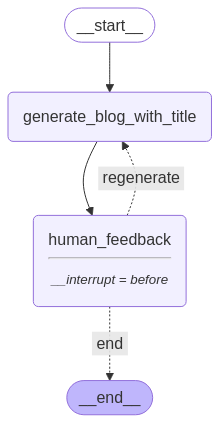

In [7]:
graph = BlogGenGraph().create_graph()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [8]:
youtubelink = "https://www.youtube.com/watch?v=SmyPTnlqhlk"
thread = {"configurable": {"thread_id": "1"}}

In [9]:
for event in graph.stream({"yt_url": youtubelink},thread, stream_mode="values"):
    content = event.get("blog_content")
    print(content)

None
# 10 Mind-Bending Algorithms That Changed the World: From Quantum Computing to Game Development

Have you ever woken up in the middle of the night in a panic, wondering how to extract a polygonal mesh from an ISO surface in a 3D discrete scalar field? Probably not, but in 1987, two programmers did just that. They created and patented the Marching Cubes algorithm, which has since been pivotal in medical imaging, allowing doctors to visualize data from CT and MRI scans.

## The Marching Cubes Algorithm

The Marching Cubes algorithm starts with a 3D scalar field, often representing data from an MRI machine. Each point in the 3D space is represented by a single number, or scalar. The algorithm begins with a single point and then takes its eight neighboring locations to form an imaginary cube. The values at these points are treated as bits in an 8-bit integer, resulting in 256 different possibilities, which point to a pre-calculated array of polygons. The algorithm then marches through

In [10]:
graph.get_state(thread).next

('human_feedback',)

In [11]:
human_feedback = "Add a more funny tone to the blog post."

In [12]:
graph.update_state(thread, {"regenerate_status": "yes", "feedback":human_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1effa7ce-b2e2-6fa8-8002-053a8fb72446'}}

In [13]:
for event in graph.stream(None,thread, stream_mode="values"):
    print(event)

{'yt_url': 'https://www.youtube.com/watch?v=SmyPTnlqhlk', 'blog_title': '10 Mind-Bending Algorithms That Changed the World: From Quantum Computing to Game Development', 'blog_content': "# 10 Mind-Bending Algorithms That Changed the World: From Quantum Computing to Game Development\n\nHave you ever woken up in the middle of the night in a panic, wondering how to extract a polygonal mesh from an ISO surface in a 3D discrete scalar field? Probably not, but in 1987, two programmers did just that. They created and patented the Marching Cubes algorithm, which has since been pivotal in medical imaging, allowing doctors to visualize data from CT and MRI scans.\n\n## The Marching Cubes Algorithm\n\nThe Marching Cubes algorithm starts with a 3D scalar field, often representing data from an MRI machine. Each point in the 3D space is represented by a single number, or scalar. The algorithm begins with a single point and then takes its eight neighboring locations to form an imaginary cube. The valu

In [14]:
graph.get_state(thread).next

('human_feedback',)

In [15]:
graph.update_state(thread, {"regenerate_status": "no"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1effa7d5-8797-68a2-8004-6457ad75c2a8'}}

In [16]:
for event in graph.stream(None,thread, stream_mode="values"):
    print(event["blog_content"])

# 10 Mind-Bending Algorithms That Changed the World: From Quantum Computing to Game Development

## Wake Up Call from the Algorithm Gods

Have you ever woken up in the middle of the night in a cold sweat, wondering how to extract a polygonal mesh of an ISO surface from a three-dimensional discrete scalar field? No? Well, in 1987, two programmers at General Electric were up late and thought, "Why not?" They created and patented the **Marching Cubes Algorithm**, which has since saved countless lives by allowing doctors to visualize data from CT and MRI scans. So, while you were sleeping, they were saving lives. Snore.

## Wave Function Collapse: The Quantum of Gaming

Ever wondered why the generated maps in your favorite video games look so darn random yet cohesive? Enter the **Wave Function Collapse (WFC)** algorithm. It’s based on the idea that a map can start as a wave of possibilities, and as the game generates the map, the wave collapses into a specific map configuration. It’s like 